# RNSA Bone Age
Fine-tuned pre-trained ResNet18 including image input only

In [0]:
import pandas as pd
import numpy as np
import math
import random
import itertools
import pickle

from sklearn.utils import shuffle
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

# !pip uninstall -y tensorflow
# !pip install tensorflow-gpu==1.14.0 
# !pip install -U --force-reinstall --no-dependencies git+https://github.com/datumbox/keras@bugfix/trainable_bn 
import keras
from keras import layers, models, regularizers, optimizers
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten, Dense, Dropout, concatenate
from keras.models import Model, Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing import image as krs_image

from classification_models.keras import Classifiers
ResNet18, preprocess_input = Classifiers.get('resnet18')

In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import files

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':'SHARED_LINK_ID'}) 
downloaded.GetContentFile('train.csv')  

In [0]:
downloaded = drive.CreateFile({'id':'SHARED_LINK_ID'}) 
downloaded.GetContentFile('test.csv')  

In [0]:
train_val = pd.read_csv('train.csv', index_col='id')
test = pd.read_csv('test.csv', index_col='id')

In [0]:
train, val = train_test_split(train_val.copy(), test_size=0.2, random_state=2020)

In [0]:
train.shape, val.shape, test.shape

((10088, 3), (2523, 3), (200, 3))

## Descriptives of dataset

In [0]:
train['gender'] = train.apply(lambda row: 'male' if row['male']==True else 'female', axis=1)
val['gender'] = val.apply(lambda row: 'male' if row['male']==True else 'female', axis=1)
test['gender'] = test.apply(lambda row: 'male' if row['male']==True else 'female', axis=1)

### Age Distributions

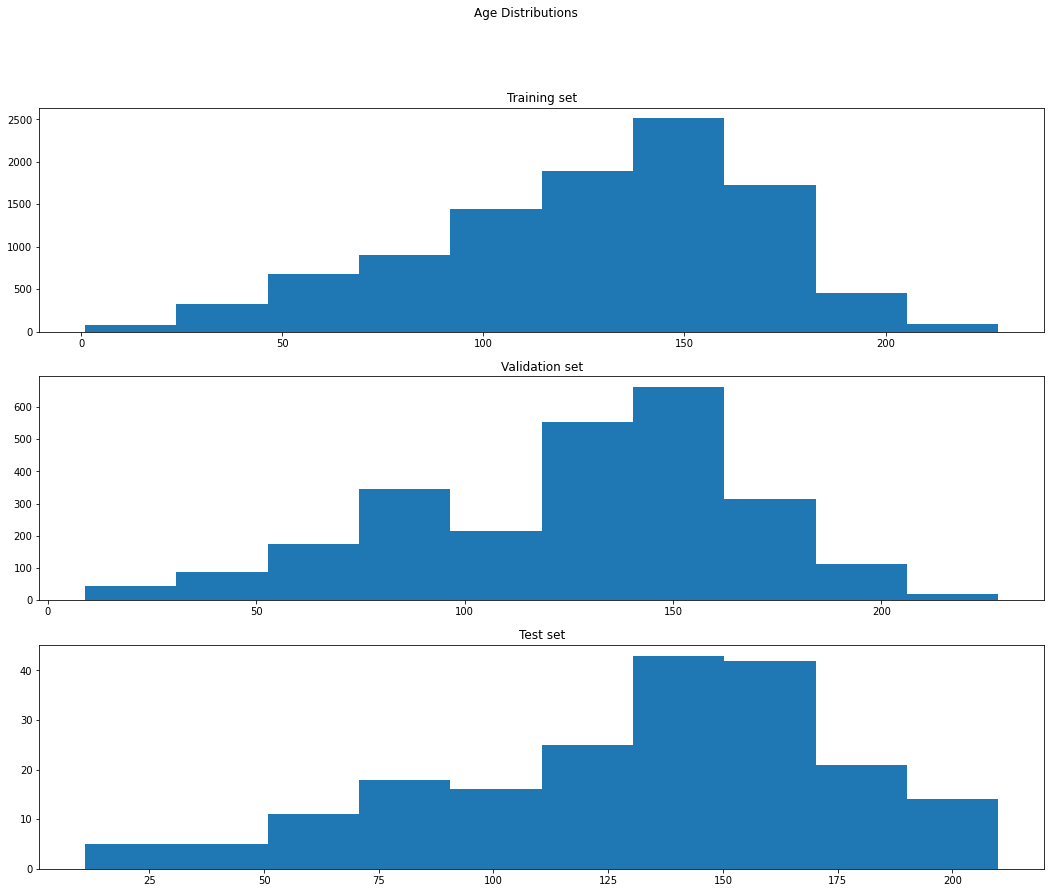

In [0]:
fig = plt.figure(figsize=(18,14)) 
fig_dims = (3, 1)
fig.suptitle('Age Distributions')

plt.subplot2grid(fig_dims, (0, 0))
plt.hist(train['boneage'])
plt.title('Training set')

plt.subplot2grid(fig_dims, (1, 0))
plt.hist(val['boneage'])
plt.title('Validation set')

plt.subplot2grid(fig_dims, (2, 0))
plt.hist(test['boneage'])
plt.title('Test set');


### Gender Distributions

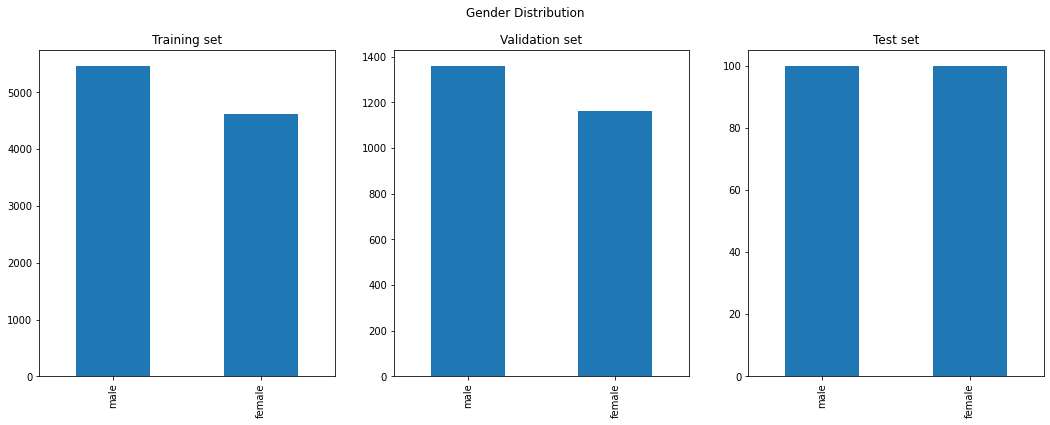

In [0]:
fig = plt.figure(figsize=(18,6)) 
fig_dims = (1, 3)
fig.suptitle('Gender Distribution')

plt.subplot2grid(fig_dims, (0, 0))
train['gender'].value_counts().plot(kind='bar', title='Training set');

plt.subplot2grid(fig_dims, (0, 1))
val['gender'].value_counts().plot(kind='bar', title='Validation set');

plt.subplot2grid(fig_dims, (0, 2))
test['gender'].value_counts().plot(kind='bar', title='Test set');

## Gender

In [0]:
train['is_male'] = train.apply(lambda row: 1 if row['male']==True else 0, axis=1)
val['is_male'] = val.apply(lambda row: 1 if row['male']==True else 0, axis=1)
test['is_male'] = test.apply(lambda row: 1 if row['male']==True else 0, axis=1)

## Upload images from drive

In [0]:
download = drive.CreateFile({'id': 'SHARED_LINK_ID'})
download.GetContentFile('resized-padded.zip')

In [0]:
!unzip -q 'resized-padded.zip'

## Image Data Generator



In [0]:
train_datagen = ImageDataGenerator(rotation_range=20, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip = True,
                                   preprocessing_function=preprocess_input)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train, 
    directory='resized_padded/training',
    x_col='img_path',
    y_col='boneage',
    target_size=(256,256),
    color_mode='rgb',
    class_mode='other',
    batch_size=64)

val_generator = test_datagen.flow_from_dataframe(
    dataframe=val, 
    directory='resized_padded/training',
    x_col='img_path',
    y_col='boneage',
    target_size=(256,256),
    color_mode='rgb',
    class_mode='other',
    batch_size=64)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    directory='resized_padded/test',
    x_col='img_path',
    y_col='boneage',
    target_size=(256,256),
    color_mode='rgb',
    class_mode='other',
    batch_size=200) # All images from test set in one batch

Found 10088 validated image filenames.
Found 2523 validated image filenames.
Found 200 validated image filenames.


## Deep Learning


### Baseline

As in initial baseline for the regression model, we can look at a central tendency measure of the validation set. In this case, we will use the mean of the validation set as the initial baseline.

In [0]:
mean_validation_set = np.mean(val.boneage)
y_pred = np.array(len(val.boneage) * [mean_validation_set])
y_true = val.boneage
baseline_mae = mean_absolute_error(y_true, y_pred)
baseline_mse = mean_squared_error(y_true, y_pred)
print('The initial baseline for the problem is a Mean Absolute Error of {} months.'.format(round(baseline_mae,2)))
print('The initial baseline for the problem is a Mean Squared Error of {}.'.format(round(baseline_mse,2)))

The initial baseline for the problem is a Mean Absolute Error of 33.68 months.
The initial baseline for the problem is a Mean Squared Error of 1683.65.


A more domain-based baseline for this project would be the MAE of pediatric
radiologists. Reddy et al. (2019) have conducted an experiment with three radiologists on the RSNA bone age dataset. The authors found a Mean Absolute Error of 6.0 months for radiologist on the RSNA bone age dataset.

__Reference__

Reddy, N. E., Rayan, J. C., Annapragada, A. V., Mahmood, N. F., Scheslinger, A. E., Zhang, W., & Kan, J. H. (2020). Bone age determination using only the index finger: a novel approach using a convolutional neural network compared with human radiologists. _Pediatric Radiology_, 50(4), 516-523.

### Fine-tuned pre-trained ResNet18 model

This notebook takes a fine-tuned pre-trained ResNet18 model with image (pixel) input. The parameters for trainable, densse_hidden_neurons and lr are taken as the optimal parameters from the optimal network incorporating both image and gender input. That is as follows:
- trainable='stage4_unit2'
- dense_hidden_neurons=32
- lr=0.001

Based on the paper by Sarić et al. (2019), where a fine-tuned VGG16 model is employed for the task of bone age prediction on the RSNA dataset, I use the Adam optimizer.

Sarić, R., Kevrić, J., Čustović, E., Jokić, D., & Beganović, N. (2019). Evaluation of Skeletal Gender and Maturity for Hand Radiographs using Deep Convolutional Neural Networks. In 2019 6th International Conference on Control, Decision and Information Technologies (CoDIT) (pp. 1115-1120). IEEE.

In [0]:
def build_model(trainable=None,
                dense_hidden_neurons=16,
                lr=0.001):
    """
    Builds a model with incorporated ResNet18 to handle image input.
    Arguments:
    - trainable: number of trainable layers in ResNet18. One of:
        - 'last_conv_layer'
        - 'stage4_unit_2'
    - dense_hidden_neurons: number of hidden neurons in the last hidden layer before the final output layer
    - lr: learning rate
    """
  
    ## ResNet18
    # Instantiate Resnet18 model trained on imagenet
    pre_trained_model = ResNet18(weights='imagenet', include_top=False,
                                 input_shape=(256, 256, 3))
  
    # If layers must be set to trainable, do that here
    if trainable=='last_conv_layer':
        from_trainable = -7

    elif trainable=='stage4_unit2':
        from_trainable = -11
  
    else: 
        from_trainable = len(pre_trained_model.layers)

    # Set layers to trainable
    for layer in pre_trained_model.layers[from_trainable:]: 
        layer.trainable = True
    # Freeze all other layers
    for layer in pre_trained_model.layers[:from_trainable]: 
        layer.trainable = False

    # Add a Global Average Pooling layer to reduce the number of parameters in the model
    pooling = layers.GlobalAveragePooling2D()(pre_trained_model.output)
    add_layer = pooling

    add_layer = Dense(dense_hidden_neurons, activation='relu')(add_layer)

    # Add output layer for regression
    output_layer = Dense(1, activation='linear')(add_layer)

    # Build new model structure
    model = Model(inputs=pre_trained_model.input, outputs=output_layer)

    optim = keras.optimizers.Adam(lr=lr)

    model.compile(optimizer=optim,
                  loss='mse',
                  metrics=['mae'])

    return model

### Fit model

I fit the model with the optimal parameters found for the VGG16 concatenated input model. That is, I set the last block of the VGG16 model to trainable and I use a learning rate of 0.001.

In [0]:
model = build_model(trainable='stage4_unit2', dense_hidden_neurons=32, lr=0.001)

In [0]:
def fit_model(model, epochs=20, verbose=2):
    """
    Fits model on train_generator and validates on val_generator. 
    Takes as input:
    - model: model to train
    - epochs: number of epochs
    - verbose: verbosity of fit_generator
    """
    early_stopping = EarlyStopping(monitor='val_mean_absolute_error', patience=10)

    checkpointer = ModelCheckpoint(filepath='keras_weights_{}.hdf5'.format(model.name),
                                   monitor='val_mean_absolute_error', 
                                   verbose=0, 
                                   save_best_only=True)

    callbacks = [early_stopping, checkpointer]
    return model.fit_generator(train_generator,
                               epochs=epochs,
                               validation_data=val_generator,
                               steps_per_epoch=math.ceil(len(train)/64),
                               validation_steps=math.ceil(len(val)/64),callbacks=callbacks,
                               verbose=verbose)

In [0]:
def plot_history(history):
    """
    Plot train/validation MAE and train/validation loss (MSE) of trained model.
    Takes as input the history.history dictionary of a trained model. 
    """    
    mae = history['mean_absolute_error']
    val_mae = history['val_mean_absolute_error']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(1, len(mae)+1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
    fig.suptitle('Training and Validation MAE and Loss')

    ax1.plot(epochs, mae)
    ax1.plot(epochs, val_mae)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('MAE')
    ax1.set_title('MAE')
    ax1.legend(['training', 'validation'])

    ax2.plot(epochs, loss)
    ax2.plot(epochs, val_loss)
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.set_title('Loss')
    ax2.legend(['training', 'validation'])

In [0]:
history = fit_model(model)

Epoch 1/20
 - 232s - loss: 3752.0345 - mean_absolute_error: 43.9141 - val_loss: 403.1459 - val_mean_absolute_error: 15.8942
Epoch 2/20
 - 214s - loss: 435.7781 - mean_absolute_error: 16.4575 - val_loss: 329.7211 - val_mean_absolute_error: 14.2414
Epoch 3/20
 - 216s - loss: 395.8764 - mean_absolute_error: 15.7662 - val_loss: 351.2497 - val_mean_absolute_error: 14.9536
Epoch 4/20
 - 216s - loss: 371.9215 - mean_absolute_error: 15.2761 - val_loss: 343.8724 - val_mean_absolute_error: 14.5949
Epoch 5/20
 - 216s - loss: 366.2732 - mean_absolute_error: 15.1594 - val_loss: 376.2520 - val_mean_absolute_error: 15.4787
Epoch 6/20
 - 216s - loss: 359.8715 - mean_absolute_error: 15.0520 - val_loss: 284.3056 - val_mean_absolute_error: 13.3572
Epoch 7/20
 - 217s - loss: 339.4809 - mean_absolute_error: 14.5558 - val_loss: 349.6219 - val_mean_absolute_error: 14.9508
Epoch 8/20
 - 217s - loss: 341.0330 - mean_absolute_error: 14.6483 - val_loss: 345.6954 - val_mean_absolute_error: 14.8678
Epoch 9/20
 - 2

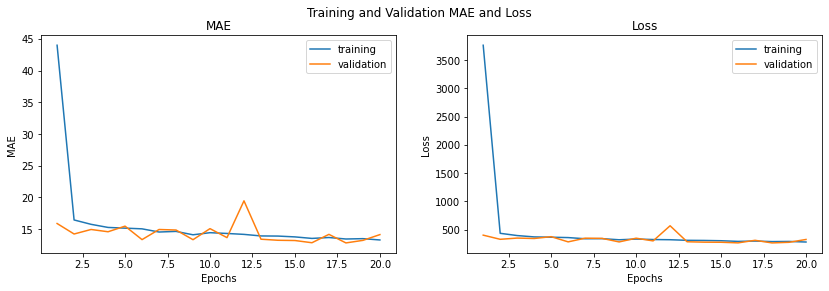

In [0]:
plot_history(history.history)

### Evaluation


In [0]:
best_model = load_model('keras_weights_model_4.hdf5')

In [0]:
result = best_model.evaluate_generator(test_generator, steps=1)
print('The final model achieves a MAE of {} on the test set.'.format(round(result[1],2)))
print('The final model achieves a MSE of {} on the test set.'.format(round(result[0],2)))

The final model achieves a MAE of 14.61 on the test set.
The final model achieves a MSE of 342.1 on the test set.
